# Cross-Validation Strategies

## Overview

Different data scenarios require different CV strategies:

| Strategy | Best For | Key Feature |
|----------|----------|-------------|
| **KFold** | General purpose | Random splits |
| **StratifiedKFold** | Classification (imbalanced) | Preserves class distribution |
| **GroupKFold** | Grouped data | Keeps groups together |
| **TimeSeriesSplit** | Time series | Respects temporal order |
| **LeaveOneOut (LOOCV)** | Very small datasets | K=n (one sample per fold) |
| **LeavePOut** | Small datasets | Leave P samples out |
| **ShuffleSplit** | Random subsampling | Multiple random splits |
| **StratifiedShuffleSplit** | Classification + random | Stratified random splits |

This notebook explores each strategy with practical examples.

## Setup and Import

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris, load_breast_cancer, make_classification
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    GroupKFold,
    TimeSeriesSplit,
    LeaveOneOut,
    LeavePOut,
    ShuffleSplit,
    StratifiedShuffleSplit,
    cross_val_score
)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

np.random.seed(42)
print("✓ Libraries imported successfully")

✓ Libraries imported successfully


## 1. KFold - Basic Random Splits

**Use Case**: General-purpose CV for regression or balanced classification

**Parameters**:
- `n_splits`: Number of folds (K)
- `shuffle`: Shuffle data before splitting (recommended)
- `random_state`: Seed for reproducibility

In [2]:
# Load data
iris = load_iris()
X, y = iris.data, iris.target

print("Dataset: Iris")
print(f"Samples: {len(X)}, Features: {X.shape[1]}")
print(f"Classes: {np.unique(y)}")

# Create KFold splitter
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nKFold Splits (K=5):")
print("=" * 60)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X), 1):
    print(f"\nFold {fold}:")
    print(f"  Train indices: {len(train_idx)} samples, first 5: {train_idx[:5]}")
    print(f"  Test indices:  {len(test_idx)} samples, first 5: {test_idx[:5]}")
    print(f"  Test class distribution: {np.bincount(y[test_idx])}")

Dataset: Iris
Samples: 150, Features: 4
Classes: [0 1 2]

KFold Splits (K=5):

Fold 1:
  Train indices: 120 samples, first 5: [0 1 2 3 4]
  Test indices:  30 samples, first 5: [ 9 12 18 19 26]
  Test class distribution: [10  9 11]

Fold 2:
  Train indices: 120 samples, first 5: [1 2 3 5 6]
  Test indices:  30 samples, first 5: [ 0  4 10 11 15]
  Test class distribution: [13 10  7]

Fold 3:
  Train indices: 120 samples, first 5: [0 1 2 3 4]
  Test indices:  30 samples, first 5: [ 5  7 23 24 25]
  Test class distribution: [12 10  8]

Fold 4:
  Train indices: 120 samples, first 5: [0 1 4 5 7]
  Test indices:  30 samples, first 5: [ 2  3  6  8 13]
  Test class distribution: [ 8 10 12]

Fold 5:
  Train indices: 120 samples, first 5: [0 2 3 4 5]
  Test indices:  30 samples, first 5: [ 1 14 20 21 37]
  Test class distribution: [ 7 11 12]


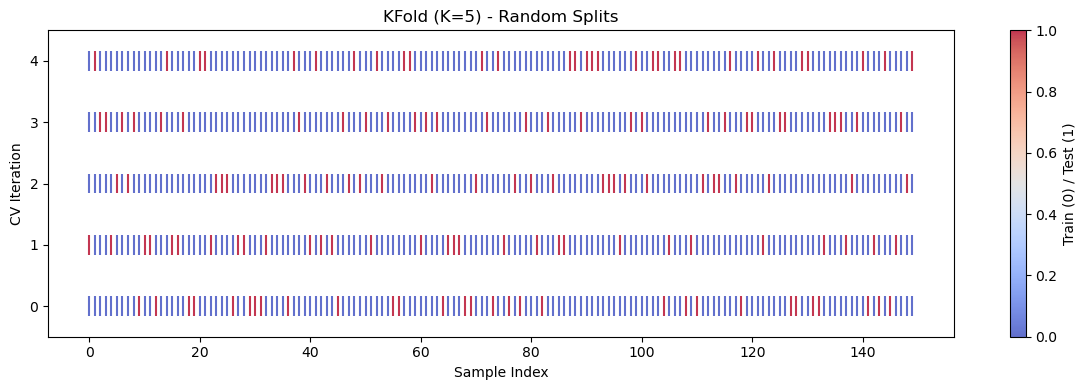

In [3]:
# Visualize KFold splits
def visualize_cv_splits(cv_splitter, X, y, title):
    """Visualize train/test splits"""
    fig, ax = plt.subplots(figsize=(12, 4))
    
    for i, (train, test) in enumerate(cv_splitter.split(X, y)):
        # Create mask for visualization
        mask = np.zeros(len(X))
        mask[test] = 1
        
        ax.scatter(range(len(X)), [i] * len(X), c=mask, 
                  cmap='coolwarm', marker='|', s=200, alpha=0.8)
    
    ax.set_xlabel('Sample Index')
    ax.set_ylabel('CV Iteration')
    ax.set_title(title)
    ax.set_yticks(range(cv_splitter.get_n_splits()))
    ax.set_ylim(-0.5, cv_splitter.get_n_splits() - 0.5)
    plt.colorbar(ax.collections[0], ax=ax, label='Train (0) / Test (1)')
    plt.tight_layout()
    plt.show()

visualize_cv_splits(kfold, X, y, 'KFold (K=5) - Random Splits')

In [4]:
# Use KFold with cross_val_score
model = LogisticRegression(max_iter=1000, random_state=42)

# Method 1: Pass cv as integer
scores1 = cross_val_score(model, X, y, cv=5)

# Method 2: Pass cv object
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
scores2 = cross_val_score(model, X, y, cv=kfold)

print("Cross-Validation Scores:")
print(f"  cv=5 (default):        {scores1.mean():.4f} ± {scores1.std():.4f}")
print(f"  cv=KFold(shuffle=True): {scores2.mean():.4f} ± {scores2.std():.4f}")

Cross-Validation Scores:
  cv=5 (default):        0.9733 ± 0.0249
  cv=KFold(shuffle=True): 0.9733 ± 0.0249


## 2. StratifiedKFold - Preserving Class Distribution

**Use Case**: Classification with imbalanced classes

**Why Important**: Regular KFold might create folds with very different class distributions, leading to unreliable estimates.

In [5]:
# Create imbalanced dataset
X_imb, y_imb = make_classification(
    n_samples=1000,
    n_features=20,
    n_classes=3,
    n_informative=15,
    n_redundant=5,
    weights=[0.6, 0.3, 0.1],  # Imbalanced!
    random_state=42
)

print("Imbalanced Dataset:")
print(f"Total samples: {len(y_imb)}")
print(f"Class distribution: {np.bincount(y_imb)}")
print(f"Class percentages: {np.bincount(y_imb) / len(y_imb) * 100}")

# Compare KFold vs StratifiedKFold
print("\n" + "=" * 70)
print("COMPARISON: KFold vs StratifiedKFold")
print("=" * 70)

# Regular KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
print("\nKFold (no stratification):")
for fold, (train_idx, test_idx) in enumerate(kfold.split(X_imb), 1):
    test_dist = np.bincount(y_imb[test_idx])
    test_pct = test_dist / len(test_idx) * 100
    print(f"  Fold {fold}: {test_dist} → {test_pct.round(1)}%")

# Stratified KFold
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("\nStratifiedKFold (preserves distribution):")
for fold, (train_idx, test_idx) in enumerate(skfold.split(X_imb, y_imb), 1):
    test_dist = np.bincount(y_imb[test_idx])
    test_pct = test_dist / len(test_idx) * 100
    print(f"  Fold {fold}: {test_dist} → {test_pct.round(1)}%")

print("\n✓ StratifiedKFold maintains consistent class distribution across folds!")

Imbalanced Dataset:
Total samples: 1000
Class distribution: [596 300 104]
Class percentages: [59.6 30.  10.4]

COMPARISON: KFold vs StratifiedKFold

KFold (no stratification):
  Fold 1: [127  55  18] → [63.5 27.5  9. ]%
  Fold 2: [115  59  26] → [57.5 29.5 13. ]%
  Fold 3: [116  58  26] → [58. 29. 13.]%
  Fold 4: [119  68  13] → [59.5 34.   6.5]%
  Fold 5: [119  60  21] → [59.5 30.  10.5]%

StratifiedKFold (preserves distribution):
  Fold 1: [120  60  20] → [60. 30. 10.]%
  Fold 2: [119  60  21] → [59.5 30.  10.5]%
  Fold 3: [119  60  21] → [59.5 30.  10.5]%
  Fold 4: [119  60  21] → [59.5 30.  10.5]%
  Fold 5: [119  60  21] → [59.5 30.  10.5]%

✓ StratifiedKFold maintains consistent class distribution across folds!


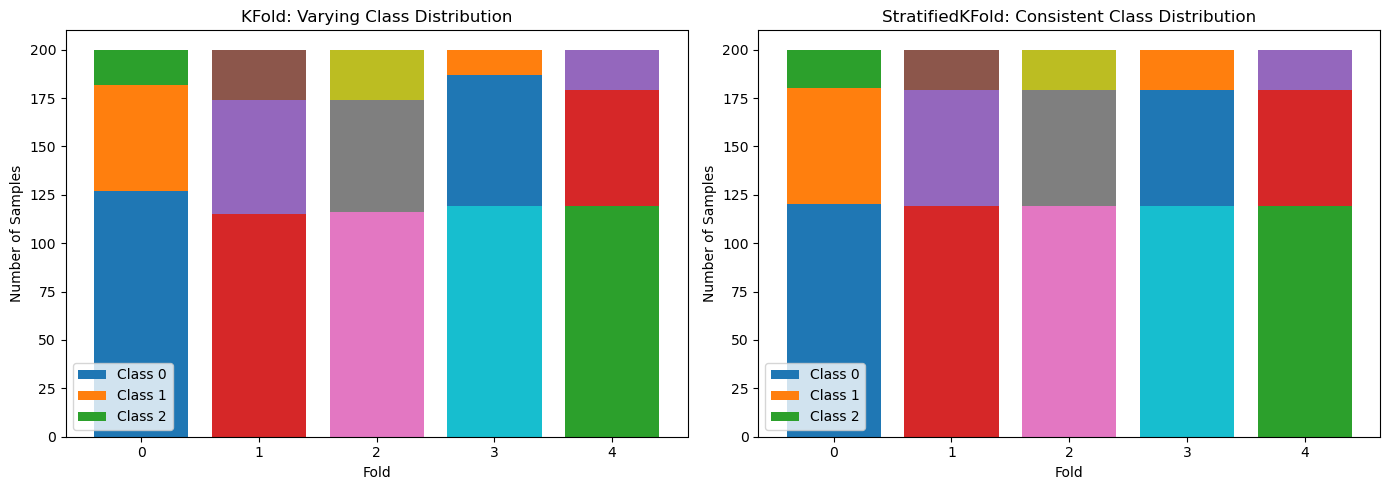

In [6]:
# Visualize both
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# KFold
for i, (train, test) in enumerate(kfold.split(X_imb)):
    test_classes = y_imb[test]
    for cls in range(3):
        count = (test_classes == cls).sum()
        ax1.bar(i, count, bottom=sum((test_classes == c).sum() for c in range(cls)), 
               label=f'Class {cls}' if i == 0 else '')

ax1.set_xlabel('Fold')
ax1.set_ylabel('Number of Samples')
ax1.set_title('KFold: Varying Class Distribution')
ax1.legend()

# StratifiedKFold
for i, (train, test) in enumerate(skfold.split(X_imb, y_imb)):
    test_classes = y_imb[test]
    for cls in range(3):
        count = (test_classes == cls).sum()
        ax2.bar(i, count, bottom=sum((test_classes == c).sum() for c in range(cls)),
               label=f'Class {cls}' if i == 0 else '')

ax2.set_xlabel('Fold')
ax2.set_ylabel('Number of Samples')
ax2.set_title('StratifiedKFold: Consistent Class Distribution')
ax2.legend()

plt.tight_layout()
plt.show()

## 3. GroupKFold - Keeping Groups Together

**Use Case**: Data with natural groups (e.g., multiple samples from same patient, user, or location)

**Important**: Prevents data leakage by ensuring same group doesn't appear in both train and test.

In [7]:
# Create grouped dataset (e.g., medical data from patients)
n_samples = 100
n_features = 20

# Each patient has 5 measurements
groups = np.repeat(np.arange(20), 5)  # 20 patients, 5 samples each
X_grouped = np.random.randn(n_samples, n_features)
y_grouped = np.random.randint(0, 2, n_samples)

print("Grouped Dataset Example:")
print(f"Total samples: {n_samples}")
print(f"Number of groups (patients): {len(np.unique(groups))}")
print(f"Samples per group: {n_samples // len(np.unique(groups))}")
print(f"\nFirst 10 group labels: {groups[:10]}")

# Regular KFold (WRONG for grouped data)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
print("\n" + "=" * 60)
print("KFold (WRONG - groups in both train and test):")
print("=" * 60)

for fold, (train_idx, test_idx) in enumerate(kfold.split(X_grouped), 1):
    train_groups = set(groups[train_idx])
    test_groups = set(groups[test_idx])
    overlap = train_groups & test_groups
    print(f"Fold {fold}: {len(overlap)} groups appear in BOTH train and test! ⚠️")

# GroupKFold (CORRECT)
gkfold = GroupKFold(n_splits=5)
print("\n" + "=" * 60)
print("GroupKFold (CORRECT - groups kept separate):")
print("=" * 60)

for fold, (train_idx, test_idx) in enumerate(gkfold.split(X_grouped, y_grouped, groups), 1):
    train_groups = set(groups[train_idx])
    test_groups = set(groups[test_idx])
    overlap = train_groups & test_groups
    print(f"Fold {fold}:")
    print(f"  Train: {len(train_groups)} groups, {len(train_idx)} samples")
    print(f"  Test:  {len(test_groups)} groups, {len(test_idx)} samples")
    print(f"  Overlap: {len(overlap)} groups ✓")

print("\n✓ GroupKFold prevents data leakage in grouped scenarios!")

Grouped Dataset Example:
Total samples: 100
Number of groups (patients): 20
Samples per group: 5

First 10 group labels: [0 0 0 0 0 1 1 1 1 1]

KFold (WRONG - groups in both train and test):
Fold 1: 13 groups appear in BOTH train and test! ⚠️
Fold 2: 13 groups appear in BOTH train and test! ⚠️
Fold 3: 14 groups appear in BOTH train and test! ⚠️
Fold 4: 10 groups appear in BOTH train and test! ⚠️
Fold 5: 11 groups appear in BOTH train and test! ⚠️

GroupKFold (CORRECT - groups kept separate):
Fold 1:
  Train: 16 groups, 80 samples
  Test:  4 groups, 20 samples
  Overlap: 0 groups ✓
Fold 2:
  Train: 16 groups, 80 samples
  Test:  4 groups, 20 samples
  Overlap: 0 groups ✓
Fold 3:
  Train: 16 groups, 80 samples
  Test:  4 groups, 20 samples
  Overlap: 0 groups ✓
Fold 4:
  Train: 16 groups, 80 samples
  Test:  4 groups, 20 samples
  Overlap: 0 groups ✓
Fold 5:
  Train: 16 groups, 80 samples
  Test:  4 groups, 20 samples
  Overlap: 0 groups ✓

✓ GroupKFold prevents data leakage in grouped s

## 4. TimeSeriesSplit - Respecting Temporal Order

**Use Case**: Time series forecasting, temporal data

**Key Feature**: Training always on past data, testing on future data (no shuffle!)

```
Fold 1: [Train]               [Test]
Fold 2: [Train Train]         [Test]
Fold 3: [Train Train Train]   [Test]
Fold 4: [Train Train Train Train] [Test]
```

In [8]:
# Create time series data (e.g., stock prices)
n_timepoints = 100
dates = pd.date_range('2020-01-01', periods=n_timepoints, freq='D')

# Synthetic time series
time_index = np.arange(n_timepoints)
X_ts = np.column_stack([time_index, np.sin(time_index / 10), np.cos(time_index / 10)])
y_ts = time_index + 10 * np.sin(time_index / 5) + np.random.randn(n_timepoints) * 2

print("Time Series Dataset:")
print(f"Timepoints: {n_timepoints}")
print(f"Date range: {dates[0].date()} to {dates[-1].date()}")

# TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

print("\n" + "=" * 70)
print("TimeSeriesSplit (expanding window):")
print("=" * 70)

for fold, (train_idx, test_idx) in enumerate(tscv.split(X_ts), 1):
    train_dates = dates[train_idx]
    test_dates = dates[test_idx]
    print(f"\nFold {fold}:")
    print(f"  Train: {len(train_idx):3d} samples | {train_dates[0].date()} to {train_dates[-1].date()}")
    print(f"  Test:  {len(test_idx):3d} samples | {test_dates[0].date()} to {test_dates[-1].date()}")

print("\n✓ Training set grows over time, always predicting the future!")

Time Series Dataset:
Timepoints: 100
Date range: 2020-01-01 to 2020-04-09

TimeSeriesSplit (expanding window):

Fold 1:
  Train:  20 samples | 2020-01-01 to 2020-01-20
  Test:   16 samples | 2020-01-21 to 2020-02-05

Fold 2:
  Train:  36 samples | 2020-01-01 to 2020-02-05
  Test:   16 samples | 2020-02-06 to 2020-02-21

Fold 3:
  Train:  52 samples | 2020-01-01 to 2020-02-21
  Test:   16 samples | 2020-02-22 to 2020-03-08

Fold 4:
  Train:  68 samples | 2020-01-01 to 2020-03-08
  Test:   16 samples | 2020-03-09 to 2020-03-24

Fold 5:
  Train:  84 samples | 2020-01-01 to 2020-03-24
  Test:   16 samples | 2020-03-25 to 2020-04-09

✓ Training set grows over time, always predicting the future!


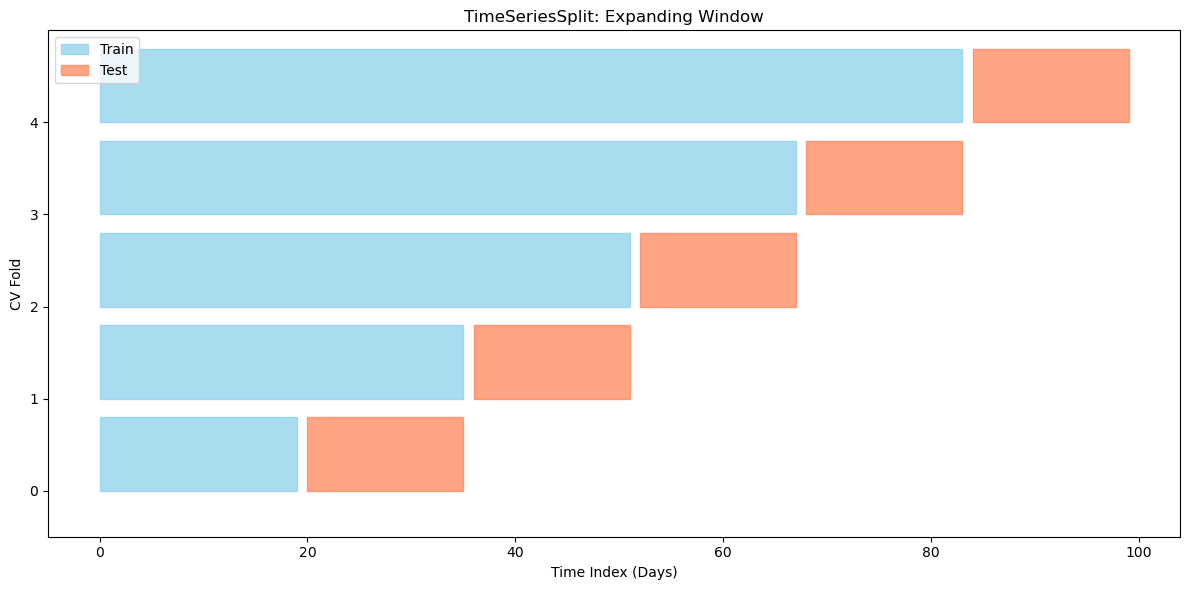

In [9]:
# Visualize TimeSeriesSplit
fig, ax = plt.subplots(figsize=(12, 6))

for i, (train, test) in enumerate(tscv.split(X_ts)):
    # Plot train and test indices
    ax.fill_between(train, i, i+0.8, color='skyblue', alpha=0.7, label='Train' if i == 0 else '')
    ax.fill_between(test, i, i+0.8, color='coral', alpha=0.7, label='Test' if i == 0 else '')

ax.set_xlabel('Time Index (Days)')
ax.set_ylabel('CV Fold')
ax.set_title('TimeSeriesSplit: Expanding Window')
ax.set_ylim(-0.5, tscv.get_n_splits())
ax.set_yticks(range(tscv.get_n_splits()))
ax.legend(loc='upper left')
plt.tight_layout()
plt.show()

In [10]:
# Use TimeSeriesSplit for model evaluation
from sklearn.linear_model import LinearRegression

model = LinearRegression()
scores = cross_val_score(model, X_ts, y_ts, cv=tscv, scoring='r2')

print("Time Series Cross-Validation Results:")
print(f"Fold scores: {scores}")
print(f"\nMean R²: {scores.mean():.4f}")
print(f"Std R²:  {scores.std():.4f}")
print("\n⚠️ For time series: later folds often have higher scores (more training data)")

Time Series Cross-Validation Results:
Fold scores: [ 6.90965700e-02 -1.24251223e+03 -4.13092104e-01 -2.21198955e+01
  6.06144613e-01]

Mean R²: -252.8740
Std R²:  494.8940

⚠️ For time series: later folds often have higher scores (more training data)


## 5. LeaveOneOut (LOOCV) - Maximum Training Data

**Use Case**: Very small datasets (<100 samples)

**Trade-off**: Most training data per fold, but K=n iterations (very slow!)

In [11]:
# Small dataset
X_small = X[:30]  # Only 30 samples
y_small = y[:30]

print(f"Small Dataset: {len(X_small)} samples")

# LeaveOneOut
loo = LeaveOneOut()

print(f"\nLeaveOneOut: {loo.get_n_splits(X_small)} folds (one per sample)")

# Show first 5 folds
print("\nFirst 5 folds:")
for fold, (train_idx, test_idx) in enumerate(loo.split(X_small), 1):
    if fold <= 5:
        print(f"Fold {fold:2d}: Train={len(train_idx)} samples, Test={len(test_idx)} sample (index {test_idx[0]})")

# Evaluate with LOOCV
model = LogisticRegression(max_iter=1000, random_state=42)
scores_loo = cross_val_score(model, X_small, y_small, cv=loo)

print(f"\nLOOCV Results:")
print(f"  Number of folds: {len(scores_loo)}")
print(f"  Mean accuracy: {scores_loo.mean():.4f}")
print(f"  Std deviation: {scores_loo.std():.4f}")

# Compare with 5-fold
scores_5fold = cross_val_score(model, X_small, y_small, cv=5)
print(f"\n5-Fold CV (for comparison):")
print(f"  Mean accuracy: {scores_5fold.mean():.4f}")
print(f"  Std deviation: {scores_5fold.std():.4f}")

print("\n💡 LOOCV: Maximum training data but very expensive (K=n)")

Small Dataset: 30 samples

LeaveOneOut: 30 folds (one per sample)

First 5 folds:
Fold  1: Train=29 samples, Test=1 sample (index 0)
Fold  2: Train=29 samples, Test=1 sample (index 1)
Fold  3: Train=29 samples, Test=1 sample (index 2)
Fold  4: Train=29 samples, Test=1 sample (index 3)
Fold  5: Train=29 samples, Test=1 sample (index 4)


ValueError: 
All the 30 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
    ~~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/opt/anaconda3/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py", line 1301, in fit
    raise ValueError(
    ...<3 lines>...
    )
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: np.int64(0)


## 6. ShuffleSplit - Random Subsampling

**Use Case**: Want to control train/test split ratio independently of K

**Advantage**: Flexible split sizes, overlapping test sets allowed

In [ ]:
# ShuffleSplit
ss = ShuffleSplit(n_splits=10, test_size=0.25, random_state=42)

print("ShuffleSplit Configuration:")
print(f"  Number of splits: 10")
print(f"  Test size: 25%")
print(f"  Train size: 75% (automatic)")

print("\nSplits:")
for fold, (train_idx, test_idx) in enumerate(ss.split(X), 1):
    if fold <= 5:
        print(f"Split {fold:2d}: Train={len(train_idx)}, Test={len(test_idx)}")

# Use with cross_val_score
model = LogisticRegression(max_iter=1000, random_state=42)
scores = cross_val_score(model, X, y, cv=ss)

print(f"\nShuffleSplit CV Results:")
print(f"  Mean accuracy: {scores.mean():.4f} ± {scores.std():.4f}")

# StratifiedShuffleSplit (for classification)
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.25, random_state=42)
scores_stratified = cross_val_score(model, X, y, cv=sss)

print(f"\nStratifiedShuffleSplit CV Results:")
print(f"  Mean accuracy: {scores_stratified.mean():.4f} ± {scores_stratified.std():.4f}")

print("\n💡 ShuffleSplit: Flexible but test sets can overlap")

## 7. Strategy Comparison on Real Dataset

In [ ]:
# Load breast cancer dataset
cancer = load_breast_cancer()
X_cancer, y_cancer = cancer.data, cancer.target

print("Breast Cancer Dataset:")
print(f"Samples: {len(X_cancer)}")
print(f"Features: {X_cancer.shape[1]}")
print(f"Classes: {cancer.target_names}")
print(f"Class distribution: {np.bincount(y_cancer)}")

# Compare different strategies
model = RandomForestClassifier(n_estimators=100, random_state=42)

strategies = {
    'KFold (K=5)': KFold(n_splits=5, shuffle=True, random_state=42),
    'KFold (K=10)': KFold(n_splits=10, shuffle=True, random_state=42),
    'StratifiedKFold (K=5)': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    'StratifiedKFold (K=10)': StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    'ShuffleSplit (n=10)': ShuffleSplit(n_splits=10, test_size=0.2, random_state=42),
    'StratifiedShuffleSplit (n=10)': StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
}

print("\n" + "=" * 70)
print("CROSS-VALIDATION STRATEGY COMPARISON")
print("=" * 70)

results = []
for name, cv_strategy in strategies.items():
    scores = cross_val_score(model, X_cancer, y_cancer, cv=cv_strategy)
    results.append({
        'Strategy': name,
        'Mean': scores.mean(),
        'Std': scores.std(),
        'Min': scores.min(),
        'Max': scores.max()
    })
    print(f"\n{name:30s}: {scores.mean():.4f} ± {scores.std():.4f}")
    print(f"{'':30s}  Range: [{scores.min():.4f}, {scores.max():.4f}]")

# Create comparison DataFrame
results_df = pd.DataFrame(results)
print("\n" + "=" * 70)
print("Summary Table:")
print("=" * 70)
print(results_df.to_string(index=False))

## 8. Decision Guide: Choosing the Right Strategy

In [ ]:
# Create comprehensive decision guide
guide = pd.DataFrame({
    'Data Type': [
        'General (balanced)',
        'Imbalanced classes',
        'Time series',
        'Grouped data',
        'Very small (<100)',
        'Large dataset',
        'Want flexible splits',
        'Imbalanced + flexible'
    ],
    'Recommended Strategy': [
        'KFold(shuffle=True)',
        'StratifiedKFold',
        'TimeSeriesSplit',
        'GroupKFold',
        'LeaveOneOut or LeavePOut',
        'ShuffleSplit (faster)',
        'ShuffleSplit',
        'StratifiedShuffleSplit'
    ],
    'Typical K': [
        '5-10',
        '5-10',
        '5',
        '3-5',
        'n (samples)',
        '3-5',
        '10-20',
        '10-20'
    ],
    'Key Parameter': [
        'shuffle=True',
        'shuffle=True',
        'n_splits',
        'n_splits',
        '-',
        'test_size',
        'test_size',
        'test_size'
    ]
})

print("\nDecision Guide: Choosing CV Strategy")
print("=" * 90)
print(guide.to_string(index=False))

print("\n" + "=" * 90)
print("IMPORTANT NOTES:")
print("=" * 90)
notes = [
    "Always set random_state for reproducibility",
    "Use shuffle=True for KFold unless data is ordered",
    "StratifiedKFold is almost always better for classification",
    "Never use regular KFold for time series (use TimeSeriesSplit)",
    "GroupKFold is crucial when samples are not independent",
    "LeaveOneOut is only for very small datasets (expensive!)",
    "Higher K = more reliable but slower",
    "ShuffleSplit allows overlapping test sets (different from KFold)"
]
for i, note in enumerate(notes, 1):
    print(f"{i}. {note}")

## Key Takeaways

### Strategy Comparison

| Strategy | Pros | Cons | Use When |
|----------|------|------|----------|
| **KFold** | Simple, fast | May create imbalanced folds | General regression |
| **StratifiedKFold** | Preserves class distribution | Only for classification | Classification (default) |
| **GroupKFold** | Prevents leakage | Unequal fold sizes | Grouped data |
| **TimeSeriesSplit** | Respects temporal order | Growing training set | Time series only |
| **LeaveOneOut** | Maximum training data | Very slow (K=n) | Tiny datasets |
| **ShuffleSplit** | Flexible, fast | Overlapping test sets | Large datasets |

### Best Practices

```python
# Default for classification
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Default for regression
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# For time series (NO SHUFFLE!)
cv = TimeSeriesSplit(n_splits=5)

# For grouped data
cv = GroupKFold(n_splits=5)
scores = cross_val_score(model, X, y, cv=cv, groups=groups)

# For fast experimentation
cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=42)
```

### Common Mistakes to Avoid

1. ❌ Using KFold for imbalanced classification → Use StratifiedKFold
2. ❌ Using shuffle with time series → Use TimeSeriesSplit (no shuffle!)
3. ❌ Not using GroupKFold for grouped data → Data leakage!
4. ❌ Forgetting random_state → Unreproducible results
5. ❌ Using LOOCV on large datasets → Too slow
6. ❌ Not setting shuffle=True for KFold → May get ordered data issues